In [1]:
import wandb


In [2]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb_api_key") 

wandb.login(key=my_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: da24m016 (da24m016-indian-institute-of-technology-madras). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
# Install required packages if not already installed (uncomment if needed)
# !pip install pytorch-lightning wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
import numpy as np
from collections import defaultdict
import os

# Ensure that your wandb API key is configured in Kaggle (via environment variable or notebook settings)


In [4]:
# Common configuration parameters that are not swept (can be overridden by sweep config)
common_config = {
    "img_size": 128,
    "num_classes": 10,       # Update if your dataset has a different number of classes
    "batch_size": 32,
    "epochs": 10
}

# Define the wandb sweep configuration
sweep_config = {
    'method': 'bayes',  # can also be 'grid' or 'random'
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'filter_organization': {
            'values': ['same', 'double', 'half']
        },
        'activation': {
            'values': ['relu', 'gelu', 'silu', 'mish']
        },
        'data_augmentation': {
            'values': [True, False]
        },
        'batch_norm': {
            'values': [True, False]
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
        'dense_neurons': {
            'values': [256, 512]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        }
    }
}

# # Create the sweep (this will return a sweep ID)
# sweep_id = wandb.sweep(sweep_config, project="da6401_assignment2")
# print("Sweep ID:", sweep_id)


In [11]:
class LitCNN(pl.LightningModule):
    def __init__(self, config):
        super(LitCNN, self).__init__()
        self.save_hyperparameters(dict(config))
        self.config = config
        
        # Determine filter configuration based on 'filter_organization'
        if config["filter_organization"] == 'same':
            conv_filters = [32] * 5
        elif config["filter_organization"] == 'double':
            conv_filters = [32, 64, 128, 256, 512]
        elif config["filter_organization"] == 'half':
            conv_filters = [512, 256, 128, 64, 32]
        else:
            raise ValueError("Unsupported filter organization")
        
        # Save conv_filters for inspection if needed
        self.conv_filters = conv_filters
        
        self.activation_fn = self._get_activation(config["activation"])
        in_channels = 3
        conv_layers = []
        # Build 5 conv-activation-(batch_norm)-maxpool blocks
        for out_channels in conv_filters:
            conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if config["batch_norm"]:
                conv_layers.append(nn.BatchNorm2d(out_channels))
            conv_layers.append(self._get_activation(config["activation"]))
            conv_layers.append(nn.MaxPool2d(kernel_size=2))
            in_channels = out_channels
        self.conv = nn.Sequential(*conv_layers)
        
        # Calculate flattened dimension after conv layers
        final_size = config["img_size"] // (2 ** 5)
        self.flatten_dim = conv_filters[-1] * final_size * final_size
        
        # Fully connected layers with dropout applied after fc1
        self.fc1 = nn.Linear(self.flatten_dim, config["dense_neurons"])
        self.dropout = nn.Dropout(config["dropout"])
        self.fc2 = nn.Linear(config["dense_neurons"], config["num_classes"])
    
    def _get_activation(self, act):
        act = act.lower()
        if act == 'relu':
            return nn.ReLU()
        elif act == 'gelu':
            return nn.GELU()
        elif act == 'silu':
            return nn.SiLU()
        elif act == 'mish':
            return nn.Mish()
        else:
            raise ValueError(f"Unsupported activation: {act}")

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc1(x)
        x = self._get_activation(self.config["activation"])(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config["learning_rate"])
        return optimizer


In [9]:
def get_transforms(config):
    if config["data_augmentation"]:  # Fix: Access dictionary key
        transform = transforms.Compose([
            transforms.Resize((config["img_size"], config["img_size"])),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((config["img_size"], config["img_size"])),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    return transform


def prepare_data(config):
    # Update the data_path to your Kaggle dataset location
    data_path = "/kaggle/input/inaturalist-dataset/inaturalist_12K/train"  # Adjust path as needed
    transform = get_transforms(config)
    dataset = datasets.ImageFolder(root=data_path, transform=transform)
    
    # Create stratified split ensuring each class is equally represented
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset.samples):
        class_indices[label].append(idx)

    train_indices = []
    val_indices = []
    for label, indices in class_indices.items():
        indices = np.array(indices)
        np.random.shuffle(indices)
        split = int(0.8 * len(indices))
        train_indices.extend(indices[:split])
        val_indices.extend(indices[split:])
    
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=2)
    return train_loader, val_loader


In [7]:
def train():
    # Initialize wandb run; the agent will supply the config parameters.
    run = wandb.init()
    config = run.config
    
    # Merge common_config with the current sweep configuration
    for key, value in common_config.items():
        if key not in config:
            config[key] = value

    # Set the run name using the hyperparameters
    run.name = f"fo_{config.filter_organization}_act_{config.activation}_aug_{config.data_augmentation}_bn_{config.batch_norm}_do_{config.dropout}_dn_{config.dense_neurons}_lr_{config.learning_rate}"
    run.save()  # Optional: saves the updated run name to wandb

    # (Rest of the training code, e.g., data preparation and model training)
    # Get data loaders based on current configuration
    train_loader, val_loader = prepare_data(config)
    
    # Set up wandb logger for PyTorch Lightning
    wandb_logger = WandbLogger(project="da6401_assignment2", log_model="all")
    
    # Instantiate the model with the current config
    model = LitCNN(config)
    
    # Create the trainer
    trainer = pl.Trainer(
        max_epochs=config.epochs,
        logger=wandb_logger,
        accelerator="gpu" if torch.cuda.is_available() else "cpu"
    )
    
    # Train the model
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    
    run.finish()


In [ ]:
# Launch the sweep agent to run multiple experiments.
# Adjust the count parameter to set the number of runs.
wandb.agent(sweep_id, function=train, count=30)


wandb: Agent Starting Run: m0j3gr0k with config:
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	filter_organization: double
wandb: 	learning_rate: 0.0001


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: 2e9s8ht8 with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: 91q3p12h with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.2
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: fyabkn65 with config:
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	filter_organization: double
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: o4ow1i9y with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filter_organization: same
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lw9c6f1z with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.3
wandb: 	filter_organization: same
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: gr9rcrkt with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: l4zvuykg with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.2
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: 7ot0a3zh with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	filter_organization: double
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hv5ml5tn with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: zdzvi2li with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.3
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: bt18qsqn with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: 3g3vs09c with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	filter_organization: double
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: d513cvdp with config:
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: qvcrnl1t with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: vwk2dycj with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	filter_organization: double
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: 8y0j92wr with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: 6fou9xrz with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mut3yf99 with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filter_organization: double
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: ot5xsox2 with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filter_organization: double
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: su4lxbaw with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: e9u9ib1b with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: euid3phq with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filter_organization: double
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: w7eypss9 with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: qmiq04xl with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filter_organization: double
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: 2w1jqqbi with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filter_organization: double
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Agent Starting Run: sge2inip with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filter_organization: half
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_augmentation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_organization' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [12]:
import torch
import torch.nn.functional as F
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# --- Load the Best Config (Manually update this from wandb results) ---
best_config = {
    "img_size": 128,
    "num_classes": 10,
    "batch_size": 32,
    "epochs": 10,
    "filter_organization": "double",
    "activation": "silu",
    "data_augmentation": True,
    "batch_norm": True,
    "dropout": 0.3,
    "dense_neurons": 256,
    "learning_rate": 1e-4
}

# --- Set up wandb for logging ---
wandb.init(project="da6401_assignment2", config=best_config)
wandb_logger = WandbLogger(project="da6401_assignment2", log_model="all")

# --- Load Data ---
train_loader, val_loader = prepare_data(best_config)  # Implement prepare_data function as in your training script

# --- Model Checkpoint Callback (Saves the best model based on validation accuracy) ---
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    dirpath="/kaggle/working/best_model_checkpoints",
    filename="best_model_cnn",
    save_top_k=1,
    mode="max"
)

# --- Train Model ---
model = LitCNN(best_config)  # Ensure this class is properly defined
trainer = pl.Trainer(
    max_epochs=best_config["epochs"],
    logger=wandb_logger,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[checkpoint_callback]
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# --- Save the Best Model ---
print(f"Best model saved at: {checkpoint_callback.best_model_path}")
wandb.log_artifact(checkpoint_callback.best_model_path, name="best_model_cnn", type="model")

wandb.finish()


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Best model saved at: /kaggle/working/best_model_checkpoints/best_model_cnn.ckpt


Test folder not found. Using validation folder as test set.
Test Loss: 1.6467046356201172
Test Accuracy: 0.422


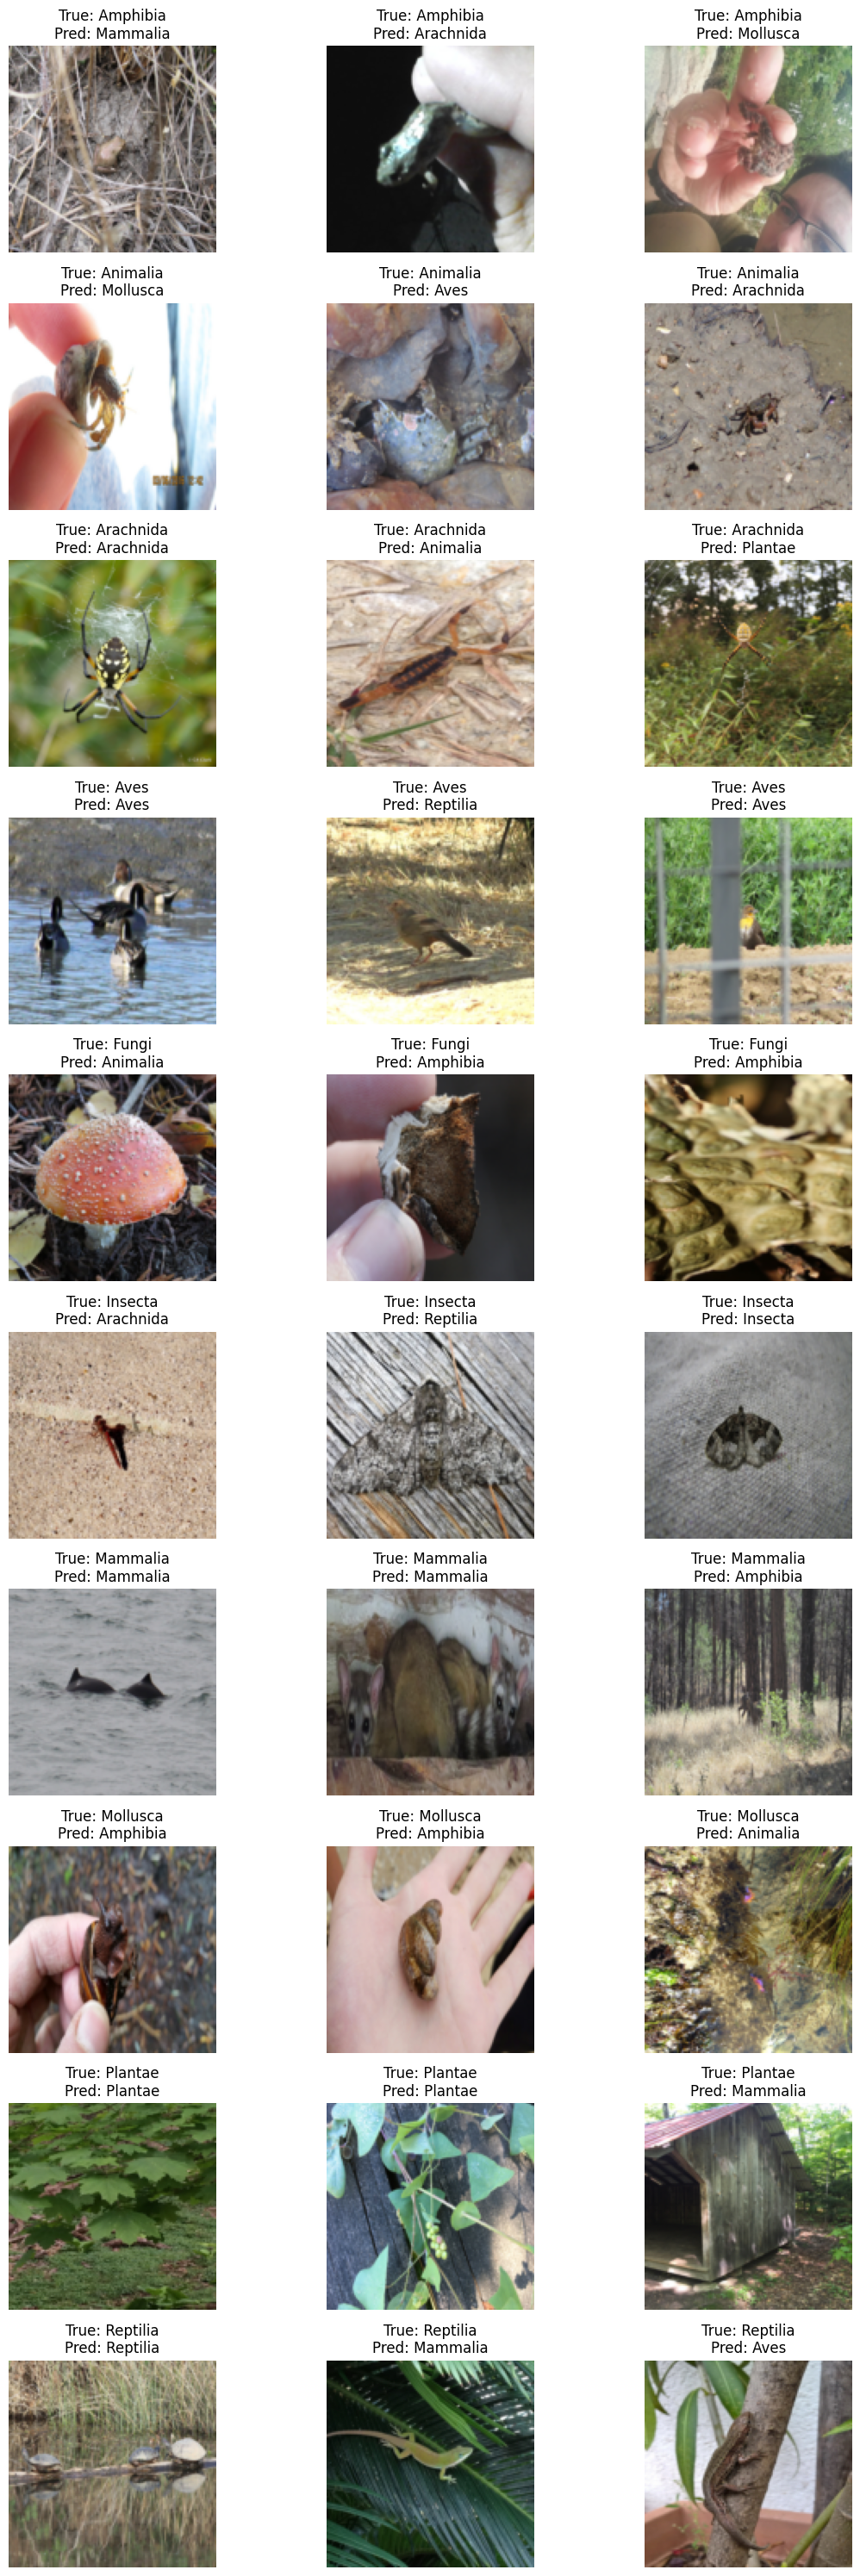

In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os

# --- Setup: Define test data path ---
test_path = "/kaggle/input/inaturalist-dataset/inaturalist_12K/test"  # Update if available
if not os.path.exists(test_path):
    print("Test folder not found. Using validation folder as test set.")
    test_path = "/kaggle/input/inaturalist-dataset/inaturalist_12K/val"  # Fallback to validation

# --- Test data transforms (no data augmentation) ---
test_transform = transforms.Compose([
    transforms.Resize((common_config["img_size"], common_config["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Load test dataset ---
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=common_config["batch_size"], shuffle=False, num_workers=2)

# --- Load the Best Model ---
# Make sure the checkpoint path and best_config match your best run.
best_config = {
    "img_size": 128,
    "num_classes": 10,
    "batch_size": 32,
    "epochs": 10,
    "filter_organization": "double",   # Example value
    "activation": "silu",                # Example value
    "data_augmentation": True,
    "batch_norm": True,
    "dropout": 0.3,
    "dense_neurons": 256,
    "learning_rate": 1e-4
}
checkpoint_path = "/kaggle/working/best_model_checkpoints/best_model_cnn.ckpt"  # Update as needed
best_model = LitCNN.load_from_checkpoint(checkpoint_path, config=best_config)
best_model.eval()
if torch.cuda.is_available():
    best_model.to("cuda")

# --- Evaluate on Test Set (Optional overall metrics) ---
test_loss = 0.0
test_correct = 0
test_total = 0

for images, labels in test_loader:
    if torch.cuda.is_available():
        images, labels = images.to("cuda"), labels.to("cuda")
    outputs = best_model(images)
    loss = F.cross_entropy(outputs, labels)
    test_loss += loss.item() * images.size(0)
    _, predicted = torch.max(outputs, 1)
    test_total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

test_loss = test_loss / test_total
test_acc = test_correct / test_total

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# --- Create a 10x3 Grid of Sample Test Images (Each row = one true class) ---
# Collect 3 images for each class (assuming classes 0 to 9)
samples_per_class = {i: [] for i in range(10)}
for img, label in test_dataset:
    if len(samples_per_class[label]) < 3:
        samples_per_class[label].append(img)
    if all(len(v) == 3 for v in samples_per_class.values()):
        break

# Get predictions for each collected sample
predictions = {}
for cls in range(10):
    imgs = torch.stack(samples_per_class[cls])  # shape [3, C, H, W]
    if torch.cuda.is_available():
        imgs = imgs.to("cuda")
    outputs = best_model(imgs)
    _, preds = torch.max(outputs, 1)
    predictions[cls] = preds.cpu().tolist()

# Function to denormalize images for visualization
def denormalize(tensor):
    # tensor shape: [C, H, W]
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    tensor = tensor * std + mean
    return tensor.clamp(0, 1)

# Get the class names from the dataset
class_names = test_dataset.classes

# Plot a 10x3 grid: one row per class (each row shows 3 images)
fig, axes = plt.subplots(10, 3, figsize=(12, 30))
for cls in range(10):
    for j in range(3):
        img = samples_per_class[cls][j]
        img = denormalize(img)
        ax = axes[cls][j]
        ax.imshow(img.permute(1, 2, 0))
        true_name = class_names[cls]
        pred_name = class_names[predictions[cls][j]]
        ax.set_title(f"True: {true_name}\nPred: {pred_name}")
        ax.axis("off")
plt.tight_layout()
plt.show()


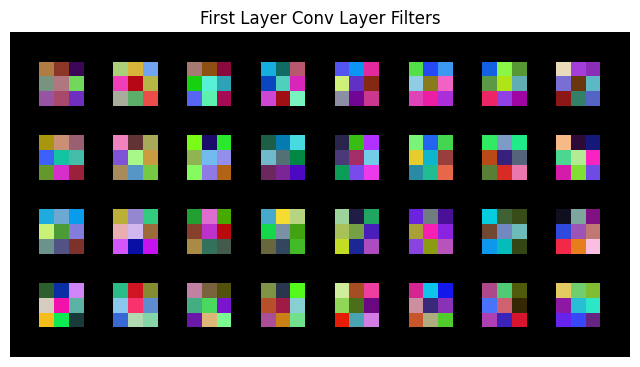

In [18]:
# Optional: Visualize all filters in the first convolutional layer.
# We assume that the first convolutional layer is the very first module in best_model.conv.
first_conv = best_model.conv[0]
weights = first_conv.weight.data.clone().cpu()

# Normalize weights for visualization
min_w = weights.min()
max_w = weights.max()
weights = (weights - min_w) / (max_w - min_w)

# Create an 8x8 grid if there are 64 filters (adjust nrow if necessary)
grid = torchvision.utils.make_grid(weights, nrow=8, padding=2)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.title("First Layer Conv Layer Filters")
plt.axis("off")
plt.show()


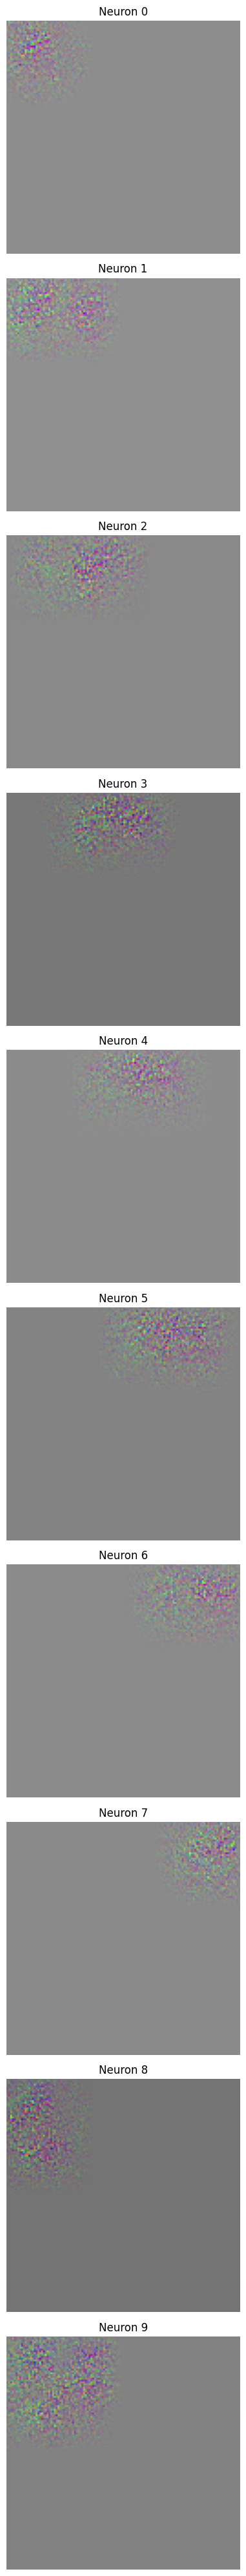

In [21]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Define a helper class for Guided Backpropagation
class GuidedBackprop:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        # Register backward hooks on all ReLU layers
        self._register_hooks()
        # Placeholder for capturing the target layer's forward output
        self.forward_output = None

    def _register_hooks(self):
        def relu_backward_hook(module, grad_in, grad_out):
            # Only allow positive gradients to flow back
            return tuple(torch.clamp(g, min=0.0) for g in grad_in)
        # Register the hook for all ReLU layers
        for module in self.model.modules():
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(relu_backward_hook)

    def hook_layer(self, layer):
        # Register a forward hook on the target layer (e.g., last conv layer)
        def forward_hook(module, input, output):
            self.forward_output = output
        self.handle = layer.register_forward_hook(forward_hook)

    def generate_gradients(self, input_image, target_neuron_idx):
        # Ensure the input image retains its gradient.
        input_image.retain_grad()  
        self.model.zero_grad()
        # Forward pass (the forward hook will capture the target layer's output)
        output = self.model(input_image)
        # Obtain the activation tensor from the hooked layer
        conv_output = self.forward_output  # shape: [batch, C, H, W]
        # Flatten the conv output for the first sample in the batch and select the target neuron
        target_activation = conv_output[0].view(-1)[target_neuron_idx]
        # Backward pass from the selected neuron's activation
        target_activation.backward(retain_graph=True)
        # Now, input_image.grad should be populated
        if input_image.grad is None:
            raise ValueError("No gradient propagated to the input image.")
        guided_gradients = input_image.grad.data.cpu().numpy()[0]
        return guided_gradients


    def remove_hook(self):
        self.handle.remove()

# ----- Guided Backpropagation for 10 Neurons in CONV5 -----

# Load your best model checkpoint (adjust the path and config as necessary)
best_config = {
    "img_size": 128,
    "num_classes": 10,
    "batch_size": 32,
    "epochs": 10,
    "filter_organization": "double",   # Example value
    "activation": "silu",                # Example value
    "data_augmentation": True,
    "batch_norm": True,
    "dropout": 0.3,
    "dense_neurons": 256,
    "learning_rate": 1e-4
}
best_model = LitCNN.load_from_checkpoint("/kaggle/working/best_model_checkpoints/best_model_cnn.ckpt", config=best_config)
best_model.eval()
if torch.cuda.is_available():
    best_model.to("cuda")

# Find the last convolutional layer in the model (CONV5 block)
last_conv = None
for module in best_model.conv:
    if isinstance(module, nn.Conv2d):
        last_conv = module  # this will overwrite until the last conv is found

if last_conv is None:
    raise ValueError("No Conv2d layer found in the model's conv block.")

# Create a GuidedBackprop object and hook the last conv layer
gbp = GuidedBackprop(best_model)
gbp.hook_layer(last_conv)

# Prepare a sample input image from the test (or validation) set.
# Here we use one image from the test_loader defined earlier.
# Ensure the input image requires gradients.
dataiter = iter(test_loader)
sample_img, _ = next(dataiter)
# Create a leaf tensor by cloning and detaching, then setting requires_grad to True
sample_img = sample_img[0:1].clone().detach().requires_grad_(True)
if torch.cuda.is_available():
    sample_img = sample_img.to("cuda")

# We'll compute guided gradients for 10 neurons.
# Here we simply choose the first 10 neurons (flattened) in the conv5 output.
guided_images = []
for neuron_idx in range(10):
    # Zero gradients before each backward pass
    best_model.zero_grad()
    sample_img.grad = None
    guided_grad = gbp.generate_gradients(sample_img, neuron_idx)
    # Normalize the gradient image for visualization
    guided_grad = (guided_grad - guided_grad.min()) / (guided_grad.max() - guided_grad.min() + 1e-8)
    guided_images.append(guided_grad.transpose(1, 2, 0))  # convert to HxWxC for plotting

# Remove the hook after use
gbp.remove_hook()

# Plot the guided backprop images in a 10x1 grid
fig, axes = plt.subplots(10, 1, figsize=(4, 40))
for i, ax in enumerate(axes):
    ax.imshow(guided_images[i])
    ax.set_title(f"Neuron {i}")
    ax.axis("off")
plt.tight_layout()
plt.show()
